In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle
import tqdm as tqdm
import pandas as pd
import copy
import torch.nn as nn

import sys
sys.path.insert(1, '../../models/Multi-Body')
from multidataset import MultiDataset
from multimodel import Net as Model

In [32]:
#Parameters to change, can change model_type to 'best' or 'last'
use_jet_pt = False
use_jet_mass = False
N = 8
model_type = 'best'
extra_name = ''
#Testing path
test_path = '../../datasets/n-subjettiness_data/test_all.npy'

#model path
model_path = '../../models/Multi-Body/models/MultiBody' + str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+'_'+ model_type + extra_name

#Loading testing dataset
test_set = MultiDataset(test_path, N, use_jet_pt, use_jet_mass)

#loading model
model = Model(N, use_jet_pt, use_jet_mass).double()
model.load_state_dict(torch.load(model_path))
model.eval()

Net(
  (dense1): Linear(in_features=20, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=50, bias=True)
  (dense4): Linear(in_features=50, out_features=50, bias=True)
  (dense5): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [33]:
classes = []
for i in range(N-1):
    if i != N-2:
        classes.append('tau_'+str(i+1)+'_'+str(0.5))
        classes.append('tau_'+str(i+1)+'_'+str(1))
        classes.append('tau_'+str(i+1)+'_'+str(2))
    else:
        classes.append('tau_'+str(i+1)+'_'+str(1))
        classes.append('tau_'+str(i+1)+'_'+str(2))
if use_jet_pt:
    classes.append('jet_pt')
if use_jet_mass:
    classes.append('jet_mass')

In [34]:
layer_names = ['dense1', 'relu', 'dropout2', 'dense2', 'relu', 'dropout2', 'dense3', 'relu', 
              'dropout1', 'dense4', 'relu', 'dropout1', 'dense5', 'softmax']
data,labels = test_set[:]
full_data = np.concatenate((data,labels),axis=1)
df_test = pd.DataFrame(full_data, columns=np.append(classes, ['background_prob', 'signal_prob']))
sig = df_test.loc[df_test['signal_prob'] == 1].drop(columns=['background_prob', 'signal_prob']).to_numpy()
L=14
A = [torch.from_numpy(sig)]+[None]*L
for i in range(L):
    A[i+1] = model._modules[layer_names[i]].forward(A[i])
print('done')

done


In [35]:
def newlayer(layer,g):

    layer = copy.deepcopy(layer)
    with torch.no_grad():
        try: layer.weight = nn.Parameter(g(layer.weight))
        except AttributeError: pass

        try: layer.bias   = nn.Parameter(g(layer.bias))
        except AttributeError: pass

    return layer

In [36]:
#Copying model
model_copy = Model(N, use_jet_pt, use_jet_mass).double()
model_copy.load_state_dict(torch.load(model_path))
model_copy.eval()

Net(
  (dense1): Linear(in_features=20, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=50, bias=True)
  (dense4): Linear(in_features=50, out_features=50, bias=True)
  (dense5): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [37]:
#Combine Dense+Activation functions
B = [A[0], A[3], A[6], A[9], A[12], A[14]]
# Backpropagate relevance scores (LRP-gamma)
rho = lambda p: p + 0.25*np.clip(p, 0, None);                       incr = lambda z: z+1e-9
R = [None]*5 + [B[-1]]
# Iterate over the layers in reverse order
for l in range(0,5)[::-1]:
    #if l <= 1:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
    #if 2 <= l <= 3: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5)
    #if l >= 4:       rho = lambda p: p;                       incr = lambda z: z+1e-9
    
    B[l] = (B[l].data).requires_grad_(True)
    
    z = newlayer(model_copy._modules[layer_names[3*l]], rho).forward(B[l]) # setp 1
    if l != 4:
        z = model_copy._modules[layer_names[3*l+1]].forward(z)
        z = incr(model_copy._modules[layer_names[3*l+2]].forward(z))
    else:
        z = incr(model_copy._modules[layer_names[3*l+1]].forward(z))

    s = (R[l+1]/z).data                                    # step 2
    (z*s).sum().backward(); c = B[l].grad                  # step 3
    R[l] = (B[l]*c).data                                   # step 4

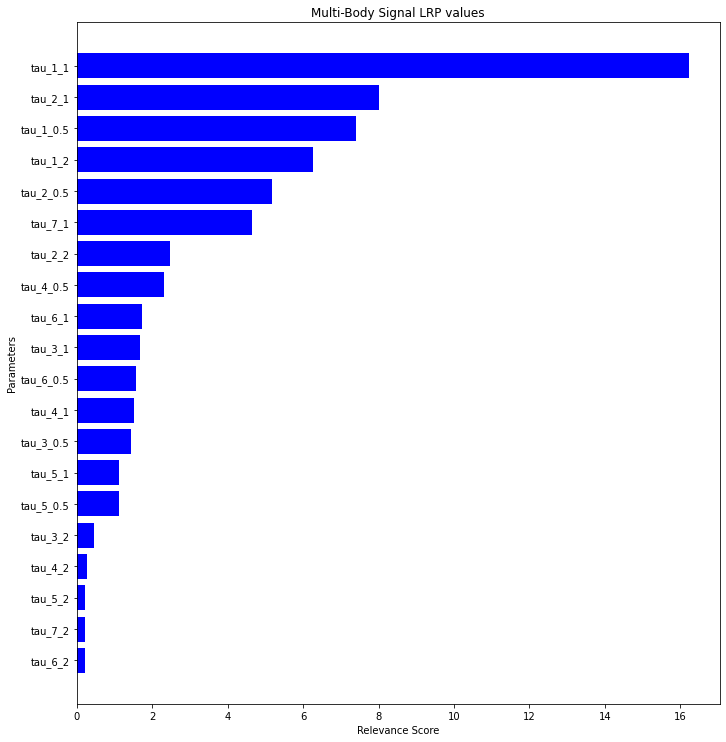

In [38]:
#Plots relevances as normalized and take absolute value
normal_rel = np.empty_like(R[0])
#Normalizes relevances for each sample
normal_rel = R[0]/np.sum(R[0].detach().numpy(), 1)[:, np.newaxis]
relevances = np.nanmean(np.abs(normal_rel), 0) #Takes mean across all jets
df_sig_rel = pd.DataFrame(dict(params=classes, rels=relevances))
df_sig_rel_sorted = df_sig_rel.sort_values('rels') #Sorts relevance values
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
max_display = 20
plt.barh('params', 'rels', data = df_sig_rel_sorted.tail(max_display), color ='blue')
plt.tight_layout()
plt.xlabel("Relevance Score")
plt.ylabel("Parameters")
plt.title("Multi-Body Signal LRP values")
#Saves plot
#plt.savefig("figures/LRP_sig_"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+".png", dpi = 150, bbox_inches='tight')
plt.show()

In [39]:
bkg = df_test.loc[df_test['background_prob'] == 1].drop(columns=['background_prob', 'signal_prob']).to_numpy()
L=14
A = [torch.from_numpy(bkg)]+[None]*L
for i in range(L):
    A[i+1] = model._modules[layer_names[i]].forward(A[i])

#Copying model
model_copy = Model(N, use_jet_pt, use_jet_mass).double()
model_copy.load_state_dict(torch.load(model_path))
model_copy.eval()

Net(
  (dense1): Linear(in_features=20, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=50, bias=True)
  (dense4): Linear(in_features=50, out_features=50, bias=True)
  (dense5): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [40]:
#Combine Dense+Activation functions
B = [A[0], A[3], A[6], A[9], A[12], A[14]]
# Backpropagate relevance scores (LRP-gamma)
rho = lambda p: p + 0.25*np.clip(p, 0, None);                       incr = lambda z: z+1e-9
R = [None]*5 + [B[-1]]
# Iterate over the layers in reverse order
for l in range(0,5)[::-1]:
    #if l <= 1:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
    #if 2 <= l <= 3: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5)
    #if l >= 4:       rho = lambda p: p;                       incr = lambda z: z+1e-9
    
    B[l] = (B[l].data).requires_grad_(True)
    
    z = newlayer(model_copy._modules[layer_names[3*l]], rho).forward(B[l]) # setp 1
    if l != 4:
        z = model_copy._modules[layer_names[3*l+1]].forward(z)
        z = incr(model_copy._modules[layer_names[3*l+2]].forward(z))
    else:
        z = incr(model_copy._modules[layer_names[3*l+1]].forward(z))

    s = (R[l+1]/z).data                                    # step 2
    (z*s).sum().backward(); c = B[l].grad                  # step 3
    R[l] = (B[l]*c).data                                   # step 4

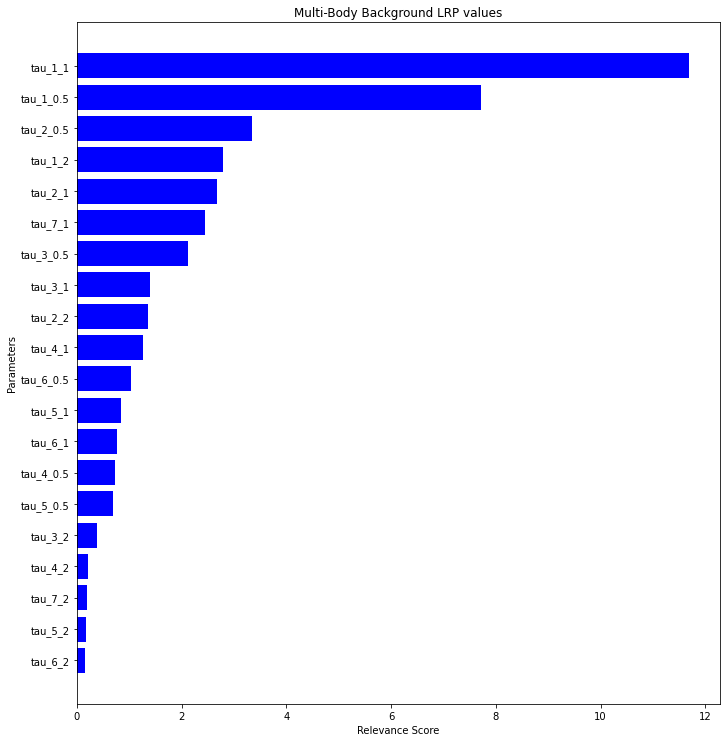

In [41]:
#Plots relevances as normalized and take absolute value
normal_rel = np.empty_like(R[0])
#Normalizes relevances for each sample
normal_rel = R[0]/np.sum(R[0].detach().numpy(), 1)[:, np.newaxis]
relevances = np.nanmean(np.abs(normal_rel), 0) #Takes mean across all jets
df_sig_rel = pd.DataFrame(dict(params=classes, rels=relevances))
df_sig_rel_sorted = df_sig_rel.sort_values('rels') #Sorts relevance values
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
max_display = 20
plt.barh('params', 'rels', data = df_sig_rel_sorted.tail(max_display), color ='blue')
plt.tight_layout()
plt.xlabel("Relevance Score")
plt.ylabel("Parameters")
plt.title("Multi-Body Background LRP values")
#Saves plot
#plt.savefig("figures/LRP_bkg_"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+".png", dpi = 150, bbox_inches='tight')
plt.show()